In [10]:
import json
import os
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
import matplotlib.pyplot as plt
from tqdm import tqdm

In [11]:
def poisson(n_samples, lambda_like=2.0, seed=20):
    np.random.seed(seed)
    data = np.random.poisson(lambda_like, n_samples)
    return data

def load_config(config_file="config.json"):
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def pushforward_exp_mean_std(mu, sigma):
    mu = float(np.asarray(mu).squeeze())
    sigma = float(np.asarray(sigma).squeeze())
    if sigma < 0:
        raise ValueError(f"sigma must be nonnegative, got {sigma}")

    mean = np.exp(mu + 0.5 * sigma**2)
    var  = (np.exp(sigma**2) - 1.0) * np.exp(2.0 * mu + sigma**2)
    std  = np.sqrt(var)
    return float(mean), float(std)


def traces_to_lambda_moments(mu_trace, sigma_trace):
    mu_trace = np.asarray(mu_trace, dtype=float).reshape(-1)
    sigma_trace = np.asarray(sigma_trace, dtype=float).reshape(-1)

    if mu_trace.shape[0] != sigma_trace.shape[0]:
        raise ValueError("mu_trace and sigma_trace must have the same length")

    mean = np.exp(mu_trace + 0.5 * sigma_trace**2)
    var  = (np.exp(sigma_trace**2) - 1.0) * np.exp(2.0 * mu_trace + sigma_trace**2)
    std  = np.sqrt(var)
    return mean, std

In [ ]:
config_file = 'exp_config.json'
config = load_config(config_file)

lambda_like = config['lambda_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
max_iters = 50_000#config['max_iters']
data = poisson(n_samples)


In [13]:
def model(y):
    lambd = numpyro.sample('lambd', dist.Gamma(alpha_prior, beta_prior))
    numpyro.sample('y', dist.Exponential(1/lambd), obs=y)

y_data = jnp.array(data)
optimizer = Adam(1e-2) # NumPyro's default value is 1e-2

single_mc_elbo = Trace_ELBO()
multi_mc_elbo = Trace_ELBO(num_particles=100)

single_mc_guide = AutoNormal(model)
multi_mc_guide = AutoNormal(model)

single_mc_svi = SVI(model, single_mc_guide, optimizer, loss=single_mc_elbo)
multi_mc_svi = SVI(model, multi_mc_guide, optimizer, loss=multi_mc_elbo)

def run_svi(rng_key, y_data, svi_model):
    @jax.jit
    def run_single_svi_loop(rng_key, y_data):
        svi_state = svi_model.init(rng_key, y_data)
        def body_fn(i, val):
            svi_state, tracker = val
            svi_state, loss = svi_model.update(svi_state, y_data)
            params = svi_model.get_params(svi_state)
            tracker = {
                'mu_loc': tracker['mu_loc'].at[i].set(params['lambd_auto_loc']),
                'std_loc': tracker['std_loc'].at[i].set(params['lambd_auto_scale'])
            }
            return svi_state, tracker
        tracker = {
            'mu_loc': jnp.zeros(max_iters),
            'std_loc': jnp.zeros(max_iters)
        }
        final_state, final_tracker = jax.lax.fori_loop(0, max_iters, body_fn, (svi_state, tracker))
        final_elbo = svi_model.evaluate(final_state, y_data)
        return final_elbo, final_tracker
    return run_single_svi_loop(rng_key, y_data)

single_elbo, single_tracker = run_svi(jax.random.PRNGKey(0), y_data, single_mc_svi)
multi_elbo, multi_tracker = run_svi(jax.random.PRNGKey(10), y_data, multi_mc_svi)

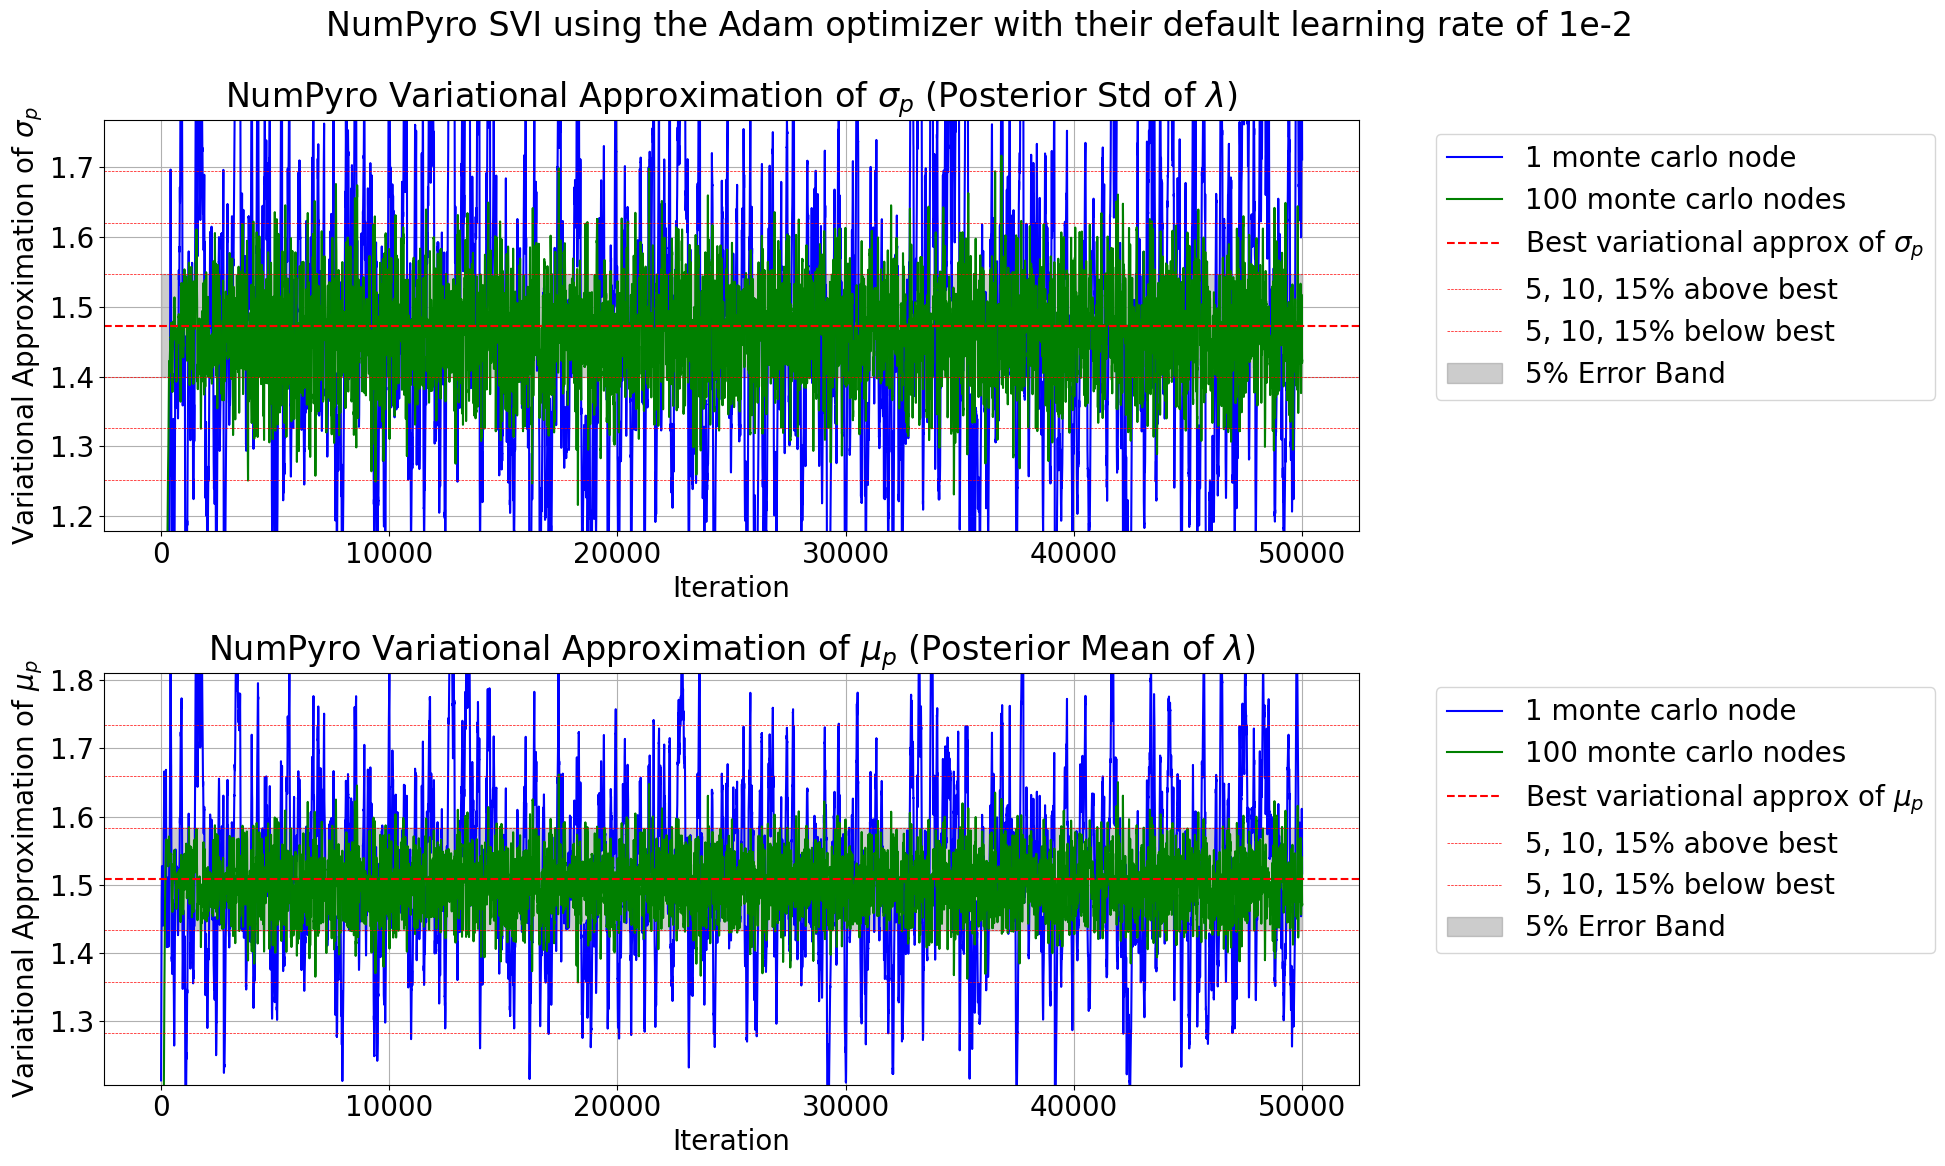

In [14]:
single_mus, single_stds = traces_to_lambda_moments(
    single_tracker['mu_loc'], single_tracker['std_loc'])
multi_mus, multi_stds = traces_to_lambda_moments(
    multi_tracker['mu_loc'], multi_tracker['std_loc'])

best_mu_unc = config['best_mean']
best_sigma_unc = config['best_std']
best_mu, best_sigma = pushforward_exp_mean_std(best_mu_unc, best_sigma_unc)

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_mus, label='1 monte carlo node', color='blue')
axs[1].plot(multi_mus, label='100 monte carlo nodes', color='green')

axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best variational approx of $\mu_p$')
axs[1].set_title(r'NumPyro Variational Approximation of $\mu_p$ (Posterior Mean of $\lambda$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].grid()

axs[0].plot(single_stds, label='1 monte carlo node', color='blue')
axs[0].plot(multi_stds, label='100 monte carlo nodes', color='green')

axs[0].axhline(best_sigma, color='red', linestyle='--', label=r'Best variational approx of $\sigma_p$')
axs[0].set_title(r'NumPyro Variational Approximation of $\sigma_p$ (Posterior Std of $\lambda$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

axs[0].grid()

for i in [5, 10, 15]:
    axs[1].axhline(best_mu * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(best_mu * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(best_sigma * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(best_sigma * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_sigma*0.95, best_sigma*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_ylim((best_sigma * 0.8, best_sigma * 1.2))
axs[1].set_ylim((best_mu * 0.8, best_mu * 1.2))

plt.suptitle('NumPyro SVI using the Adam optimizer with their default learning rate of 1e-2')
plt.tight_layout()
plt.show()

Let's further tune the learning rate to 1e-3.

In [15]:
tuned_optimizer = Adam(1e-3) # NumPyro's default value is 1e-2


single_mc_guide_tuned = AutoNormal(model)
multi_mc_guide_tuned = AutoNormal(model)

single_mc_svi_tuned = SVI(model, single_mc_guide_tuned, tuned_optimizer, loss=single_mc_elbo)
multi_mc_svi_tuned = SVI(model, multi_mc_guide_tuned, tuned_optimizer, loss=multi_mc_elbo)


single_elbo_tuned, single_tracker_tuned = run_svi(jax.random.PRNGKey(0), y_data, single_mc_svi_tuned)
multi_elbo_tuned, multi_tracker_tuned = run_svi(jax.random.PRNGKey(10), y_data, multi_mc_svi_tuned)

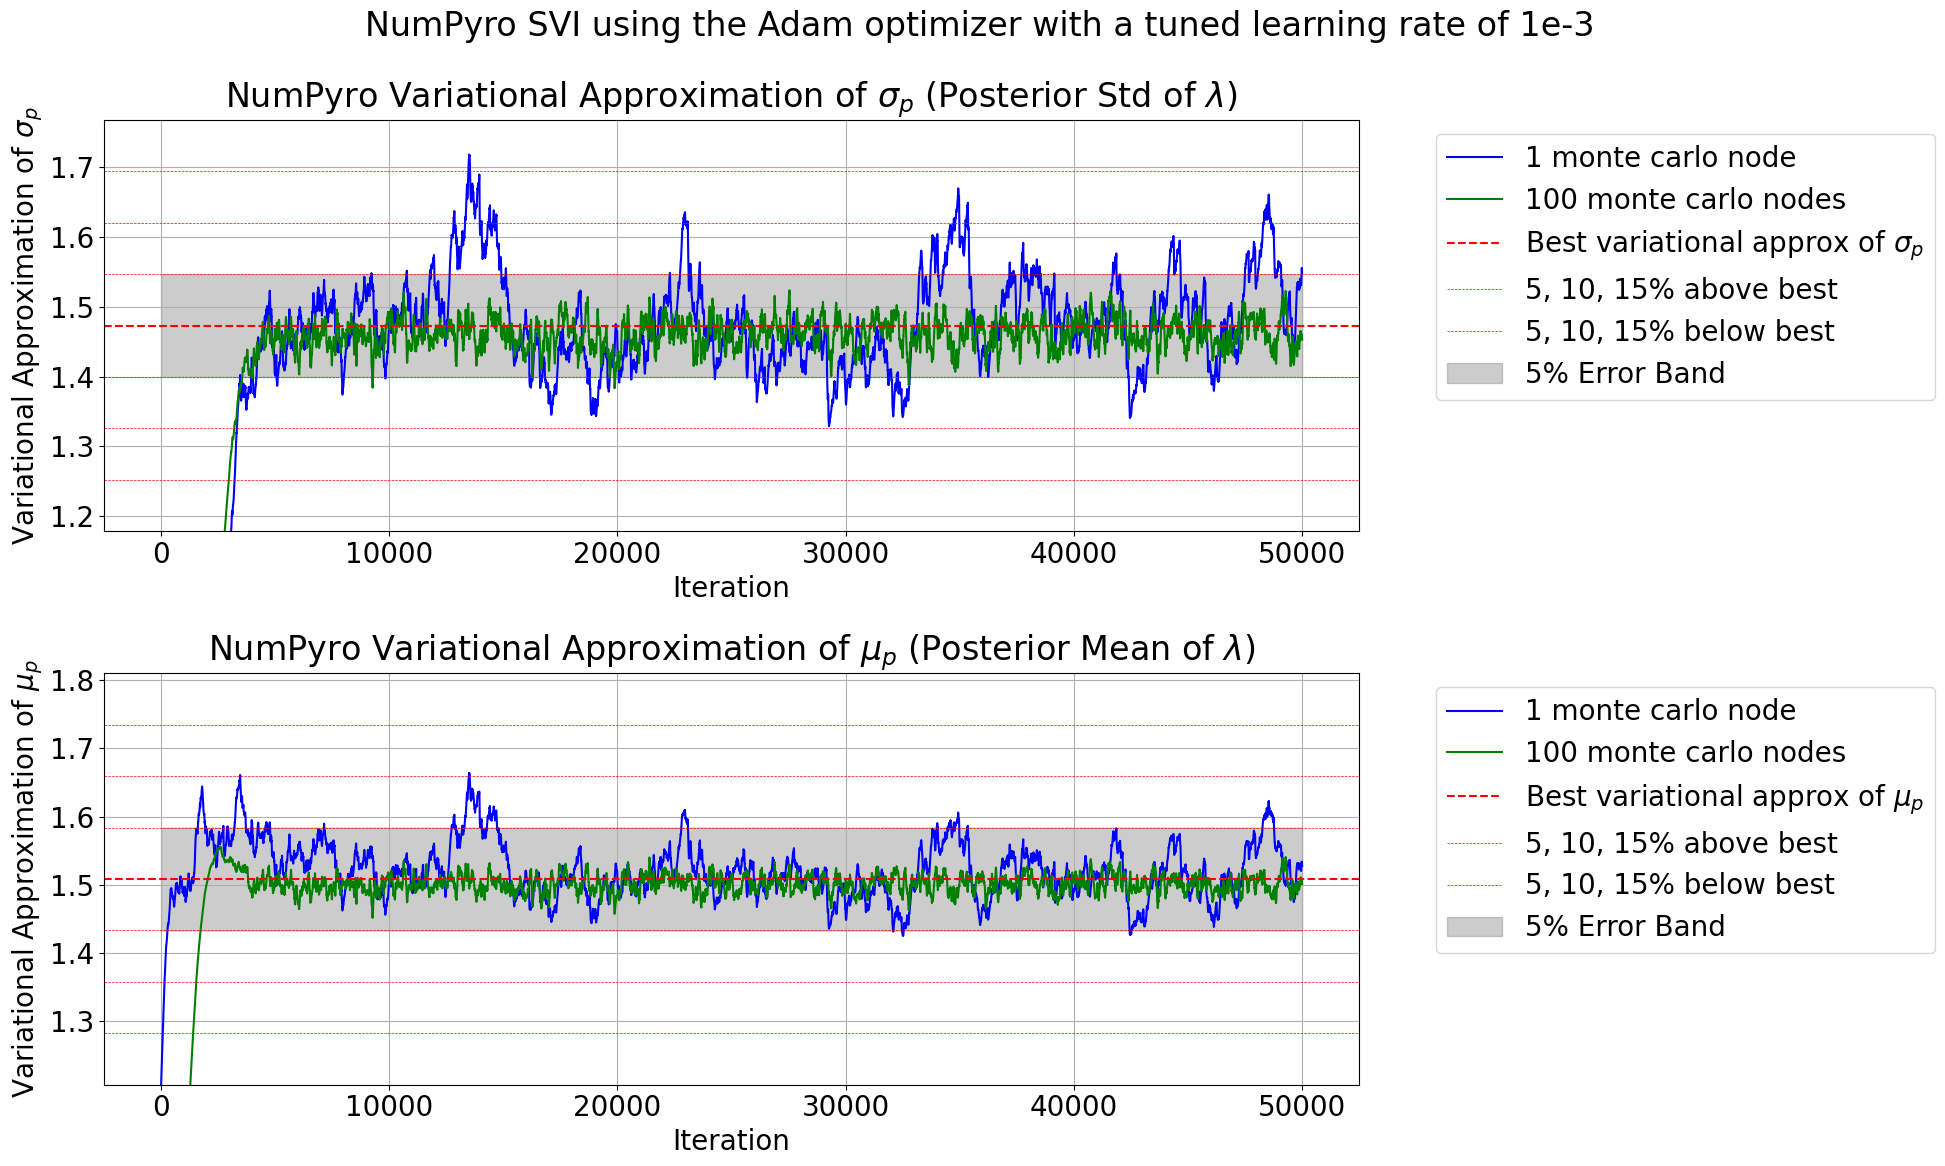

In [16]:
single_mus_tuned, single_stds_tuned = traces_to_lambda_moments(
    single_tracker_tuned['mu_loc'], single_tracker_tuned['std_loc'])
multi_mus_tuned, multi_stds_tuned = traces_to_lambda_moments(
    multi_tracker_tuned['mu_loc'], multi_tracker_tuned['std_loc'])

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_mus_tuned, label='1 monte carlo node', color='blue')
axs[1].plot(multi_mus_tuned, label='100 monte carlo nodes', color='green')

axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best variational approx of $\mu_p$')
axs[1].set_title(r'NumPyro Variational Approximation of $\mu_p$ (Posterior Mean of $\lambda$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].grid()

axs[0].plot(single_stds_tuned, label='1 monte carlo node', color='blue')
axs[0].plot(multi_stds_tuned, label='100 monte carlo nodes', color='green')

axs[0].axhline(best_sigma, color='red', linestyle='--', label=r'Best variational approx of $\sigma_p$')
axs[0].set_title(r'NumPyro Variational Approximation of $\sigma_p$ (Posterior Std of $\lambda$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

axs[0].grid()

for i in [5, 10, 15]:
    axs[1].axhline(best_mu * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(best_mu * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(best_sigma * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(best_sigma * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_sigma*0.95, best_sigma*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_ylim((best_sigma * 0.8, best_sigma * 1.2))
axs[1].set_ylim((best_mu * 0.8, best_mu * 1.2))

plt.suptitle('NumPyro SVI using the Adam optimizer with a tuned learning rate of 1e-3')
plt.tight_layout()
plt.show()